In [1]:
from windisch import *
import matplotlib.pyplot as plt

In [2]:
#update_input_parameters()
tip = TurbinesInputParameters()
tip.static()
#tip.stochastic(3)
_, array = fill_xarray_from_input_parameters(
    tip,
    scope={"year": [2020, 2030], "size": [1000,]}
)

In [3]:
wt = WindTurbineModel(
    array,
    location=(43.47381649105166, 5.274937112599782)
)

Downloaded 54.92 kB for location (43.47381649105166, 5.274937112599782)
Onshore wind turbines


In [4]:
wt.set_all()

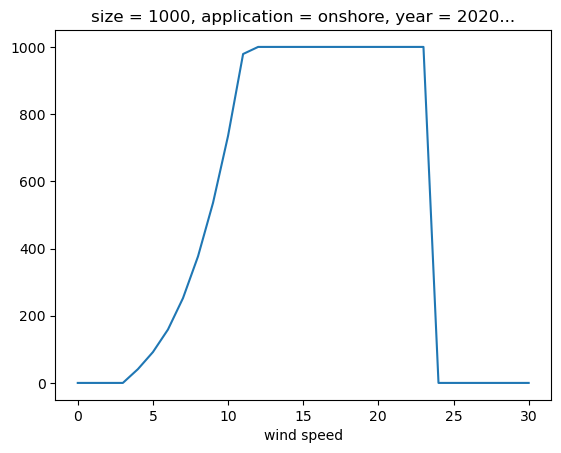

In [6]:
wt.power_curve.sel(application="onshore", year=2020).plot()

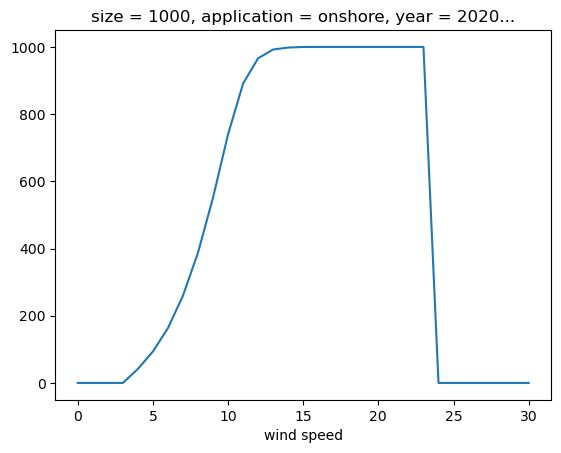

In [5]:
wt.power_curve.sel(application="onshore", year=2020).plot()

In [6]:
wt.terrain_vars["WD"]

<xarray.DataArray 'WD' (time: 721, size: 1, application: 2, year: 2, value: 1)> Size: 23kB
array([[[[[238.2509613 ],
          [238.2509613 ]],

         [[238.2509613 ],
          [238.2509613 ]]]],



       [[[[252.00219727],
          [252.00219727]],

         [[252.00219727],
          [252.00219727]]]],



       [[[[226.11431885],
          [226.11431885]],

         [[226.11431885],
...
          [113.57656097]],

         [[113.57656097],
          [113.57656097]]]],



       [[[[ 85.69570923],
          [ 85.69570923]],

         [[ 85.69570923],
          [ 85.69570923]]]],



       [[[[ 23.07023621],
          [ 23.07023621]],

         [[ 23.07023621],
          [ 23.07023621]]]]], shape=(721, 1, 2, 2, 1))
Coordinates:
    XLAT         float32 4B 43.24
    XLON         float32 4B 0.2777
    crs          int8 1B 0
    south_north  float64 8B -1.053e+06
    west_east    float64 8B -1.146e+06
  * time         (time) datetime64[ns] 6kB 2018-12-01T23:00:00 ... 2018-12-31...
  * size         (size) int64 8B 1000
  * application  (application) <U8 64B 'offshore' 'onshore'
    parameter    <U36 144B 'tower height'
  * year         (year) int64 16B 2020 2030
  * value        (value) int64 8B 0
Attributes:
    grid_mapping:   crs
    long_name:      Wind Direction
    standard_name:  wind_from_direction
    units:          degree

In [1]:
from windisch.wind_speed import fetch_wind_speed

In [4]:
a = fetch_wind_speed(43.443342426624184, 5.236754655530697)

Downloaded 419.35 kB for location (43.443342426624184, 5.236754655530697)


In [5]:
a

<xarray.Dataset> Size: 350kB
Dimensions:      (time: 8737, height: 2)
Coordinates:
  * height       (height) float32 8B 50.0 75.0
    XLAT         float32 4B 43.0
    XLON         float32 4B 9.003
    crs          int8 1B 0
    south_north  float64 8B -1.167e+06
    west_east    float64 8B -4.71e+05
  * time         (time) datetime64[ns] 70kB 2018-01-01T23:00:00 ... 2018-12-3...
Data variables:
    TKE          (time, height) float32 70kB 2.847 2.727 2.607 ... 0.1658 0.1671
    WS           (time, height) float32 70kB 21.07 21.67 20.3 ... 4.136 4.157
    RHO          (time) float32 35kB 1.222 1.222 1.222 ... 1.241 1.241 1.241
    HGT          (time) float32 35kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    LANDMASK     (time) float64 70kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/138)
    ADAPT_DT_MAX:                    15.0
    ADAPT_DT_MIN:                    3.0
    ADAPT_DT_START:                  13.0
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    ...                              ...
    eastBoundLongitude:              9.0
    verticalExtentMinimum:           50.0
    verticalExtentMaximum:           75.0
    temporalExtentMinimum:           2018-01-01T23:30:00
    temporalExtentMaximum:           2018-12-31T23:30:00
    subset_pid:                      https://wps.neweuropeanwindatlas.eu/api/...

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 5)
import GenericWindTurbinePowerCurve as GWTPC

Pnom    = 2000
Drotor  = 80
Vws     = np.arange(0,30,0.01)

for powertrain in wt.array.coords
Pwt=GWTPC.GenericWindTurbinePowerCurve(
    Vws,
    wt["power"],
    Drotor
)

plt.plot(Vws,Pwt)
plt.ylabel('wind power (kW)')
plt.xlabel('wind speed (m/s)')
plt.grid()

TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 4 dimensions

In [7]:
wt.wind_speeds["WS"]

<xarray.DataArray 'WS' (time: 8737, height: 5)> Size: 349kB
array([[ 0.        ,  0.        , 21.1655902 , 21.69213032, 22.04505095],
       [ 0.        ,  0.        , 20.3891661 , 20.8621341 , 21.1791473 ],
       [ 0.        ,  0.        , 20.34587405, 20.74528358, 21.01299321],
       ...,
       [ 0.        ,  0.        ,  1.95782728,  1.96693192,  1.97303443],
       [ 0.        ,  0.        ,  2.87387378,  2.88720278,  2.89613673],
       [ 0.        ,  0.        ,  4.13962712,  4.16000886,  4.17367001]],
      shape=(8737, 5))
Coordinates:
    XLAT         float32 4B 43.0
    XLON         float32 4B 9.003
    crs          int8 1B 0
    south_north  float64 8B -1.167e+06
    west_east    float64 8B -4.71e+05
  * height       (height) float64 40B 28.53 42.07 56.1 90.28 113.2
  * time         (time) datetime64[ns] 70kB 2018-01-01T23:00:00 ... 2018-12-3...
Attributes:
    grid_mapping:   crs
    long_name:      Horizontal Wind Speed
    standard_name:  wind_speed
    units:          m s-1
    concept_pid:    http://purl.org/aspect/wind_speed

In [18]:
wt.array.shape

(5, 2, 59, 6, 500)

<AxesSubplot: xlabel='size,application'>

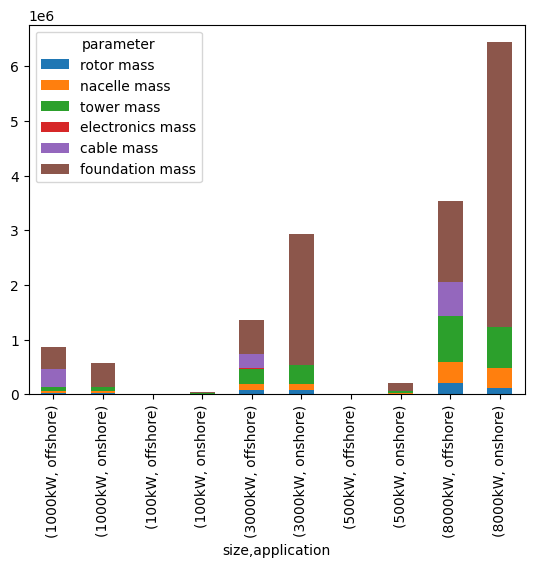

In [21]:
list_mass = [
    "rotor mass",
    "nacelle mass",
    "tower mass",
    "electronics mass",
    "cable mass",
    "foundation mass",
]
wt.array.sel(year=2020, value=0, parameter=list_mass).to_dataframe("val").unstack()["val"].plot(kind="bar", stacked=True)

In [24]:
wt.array.coords

Coordinates:
  * size         (size) <U6 '1000kW' '100kW' '3000kW' '500kW' '8000kW'
  * application  (application) <U8 'offshore' 'onshore'
  * parameter    (parameter) <U36 'access road' ... 'turbines per farm'
  * year         (year) int64 2000 2010 2020 2030 2040 2050
  * value        (value) int64 0

In [22]:
wt.array.sel(year=2020, value=0, parameter="maintenance transport").to_dataframe("val").unstack()["val"]

application,offshore,onshore
size,,
1000kW,256779.661017,6250.0
100kW,0.000000,6250.0
3000kW,256779.661017,6250.0
500kW,0.000000,6250.0
8000kW,256779.661017,6250.0


<AxesSubplot: >

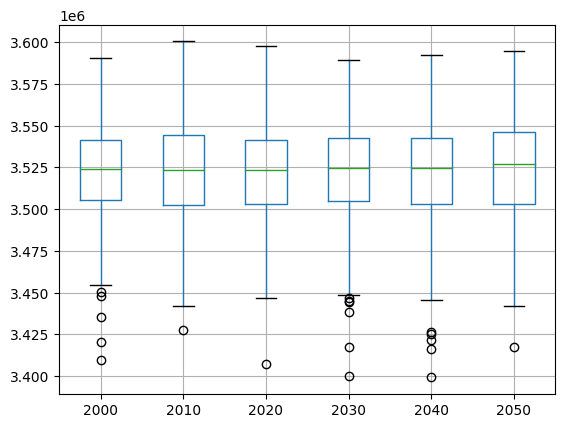

In [34]:
wt.array.sel(parameter="total mass", application="offshore", size="8000kW").to_dataframe("val").unstack()["val"].T.boxplot()

In [6]:
from windisch.model import func_tower_weight_d2h
func_tower_weight_d2h(5, 10, 3.03584782e-04, 9.68652909e00)

9762.425285500001

In [7]:
func_tower_weight_d2h(wt["rotor diameter"], wt["tower height"], 3.03584782e-04, 9.68652909e00)

<xarray.DataArray (size: 5, application: 2, year: 6, value: 1)>
array([[[[ 73374.90009306],
         [ 73374.90009306],
         [ 73374.90009306],
         [ 73374.90009306],
         [ 73374.90009306],
         [ 73374.90009306]],

        [[ 72712.91953994],
         [ 72712.91953994],
         [ 72712.91953994],
         [ 72712.91953994],
         [ 72712.91953994],
         [ 72712.91953994]]],


       [[[  9686.52909   ],
         [  9686.52909   ],
         [  9686.52909   ],
         [  9686.52909   ],
         [  9686.52909   ],
...
         [ 30434.02672168],
         [ 30434.02672168],
         [ 30434.02672168],
         [ 30434.02672168],
         [ 30434.02672168]]],


       [[[840467.97204929],
         [840467.97204929],
         [840467.97204929],
         [840467.97204929],
         [840467.97204929],
         [840467.97204929]],

        [[754455.95551841],
         [754455.95551841],
         [754455.95551841],
         [754455.95551841],
         [754455.95551841],
         [754455.95551841]]]])
Coordinates:
  * size         (size) <U6 '1000kW' '100kW' '3000kW' '500kW' '8000kW'
  * application  (application) <U8 'offshore' 'onshore'
  * year         (year) int64 2000 2010 2020 2030 2040 2050
  * value        (value) int64 0
    tower mass   (size, application, year, value) float64 7.337e+04 ... 7.545...

In [6]:
wt.array.sel(year=2020, value=0, parameter="tower mass")

<xarray.DataArray (size: 5, application: 2)>
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])
Coordinates:
  * size         (size) <U6 '1000kW' '100kW' '3000kW' '500kW' '8000kW'
  * application  (application) <U8 'offshore' 'onshore'
    parameter    <U36 'tower mass'
    year         int64 2020
    value        int64 0